# Code to take data using the scope and plot relevant histograms. Will output energy resolution and associated errors.

In [1]:
import os
import sys

#sys.path.insert(0, '..\..\scope-daq')

import MSO4102B as sdaq # This is the scope module that Sean G. wrote. You will need this module (should be on GitHub, https://github.com/ibrewer/scope-daq)
import importlib
#importlib.reload(sdaq)
import time
import h5py # This is the python library that creates files/stores data sets
import numpy as np
import matplotlib.pyplot as plt

### Enter the IP address of the scope as a string. The IP address of the scope should be set by the router (make sure both the scope and the lab laptop are plugged into the router). To check the IP address of the scope, you can go to the Utility menu and check the LAN settings. Sometimes a LAN reset is required.

In [6]:
scope = sdaq.Scope(address="169.254.2.185")

### This command creates a h5py file, desginated as "f." Documentation for h5py can be found at http://docs.h5py.org/en/stable/. 
### NOTE: Please keep the 'a' flag.  ***Also, make sure you close an open file (use f.close()) before you open a new one.***

In [3]:
f = h5py.File('pixel_12_50_y_10_13_20.h5py', 'a')

In [11]:
f.close()

In [4]:
g = h5py.File('pixel_12_50_fe_10_2_20_scaling.h5py', 'a')

### Create an array that stores the scope scaling dictionary. This will make sure that we have the scope settings for any given run.

### If you want to extract the scope scaling parameters from a file, the 5 settings are stored in the order [x zero, x incr, y zero, y mult, y offset].
### To extract the data, you could say ***data_scale = f['scope_scaling']*** and then extract the values that you want using ***data_scale[1] = x_increment***, for example.

In [5]:
scaling_dict = scope.read_scaling_config()

scaling_info = np.zeros(5)
scaling_info[0] = float(scaling_dict['XZERO'])
scaling_info[1] = float(scaling_dict['XINCR'])
scaling_info[2] = float(scaling_dict['YZERO'])
scaling_info[3] = float(scaling_dict['YMULT'])
scaling_info[4] = float(scaling_dict['YOFF'])

dset = g.create_dataset('scope_scaling', data=scaling_info)

Data source channel [1-indexed]: 1


In [102]:
test_index = g['scope_scaling']

In [103]:
print(test_index[0])

-1e-05


In [6]:
g.close()

### The get_data function will initialize a run (a full run length is 30000 traces, which takes approx. an hour and a half).

### The naming scheme for data sets is filename_run#, ex. "BC_2019703_0822_45_plateau1_initial_run1."

In [4]:
"""
    This function pulls SiPM pulses from the scope and stores them in arrays.
    
    Parameters
    ----------
    
    no_of_traces: float
        However many traces or SiPM pulses you want to record.
    data_set_name: string
        Name of the data set within the file. The naming scheme for data sets is 
        filename_run#, ex. "BurstCube_PostVibe_Cs137_061419_run1."
        
    Returns
    -------
    
    Data sets. Two data sets should be created, the scope scaling information and 
    The scope data is stored in an array (a h5py data set). h5py data sets are nice 
    because you can splice into them. In this case, the size of the array is determined by the 
    number of traces you want from the scope and number of data points the scope collects for 
    each trace; the size of the array is number of traces by amount of scope points. Each row 
    is a scope trace, so plotting/data analysis is done in a for loop that looks at each row 
    one at a time.
    
    """

def get_data(no_of_traces, data_set_name):

    # Determines number of points from each scope trace and creates an empty array
    _, last_trace = scope.read_triggered_event()
    last_trace = np.array([int(s) for s in last_trace.split(',')])
    
    curve_length = len(last_trace)
    arr = np.zeros((no_of_traces, curve_length))

    # Scaling dictionary is used to scale the scope traces to account for scope settings
    scaling_dict = scope.read_scaling_config()
    
    n_bad_comm = 0
    i = 0
    t_start = time.time()
    n_dup = 0
    single = True
    
    while i < no_of_traces:
        # Code to discount duplicates (when the scope gets stuck on a trigger):
        try: 
            _, trace = scope.read_triggered_event()
            trace = np.array([int(s) for s in trace.split(',')])
            if np.sum(trace - last_trace) == 0:
                i -= 1
                n_dup +=1
                print("%d duplicates" %(n_dup))
            else:
                last_trace = trace
                _, trace_scaled = scope.scale_data(scaling_dict, trace)
                arr[i] = trace_scaled
                if i % 1000 == 0:
                    print("At {0:d} / {1:d}".format(i, no_of_traces))
        
        # Code to override Visa errors:
        except visa.VisaIOError:
            n_bad_comm += 1
            print("Communication timeout... %d" %(n_bad_comm))
            i -= 1 
        
        i += 1       
    
        if i > 0 and i %1000 == 0 and single:
            t_now = time.time()
            single = False 
            elapsed = time.time() - t_start
            rate = float(i)/float(t_now - t_start)
            print("{2:s} ; At {0:d}/{1:d}".format(i, no_of_traces, time.strftime('%a, %d %b %Y %H:%M:%S GMT', time.localtime())))
            print("\tRate: {0:6.3f} Hz\t Elapsed: {1:6.2f} s\t Estimated total run length: {2:6.2f} s\t Estimated time remaining: {3:6.2f}".format(rate, elapsed, no_of_traces/(rate), no_of_traces/(rate) - elapsed))

        if i%1000 == 1:
            single = True
    
    t_stop = time.time()
    
    run_len = t_stop - t_start
    run_min = run_len / 60
    print("The run length was %0.3f minutes." %(run_min))

    dset = f.create_dataset(data_set_name, data=arr)
    
    return dset

### Actually take data, double check the data set name. Remember the first function input is the number of traces and the second input is the data set name

In [7]:
get_data(5000, 'run2') # take data

Data source channel [1-indexed]: 1
At 0 / 5000
Tue, 13 Oct 2020 19:56:55 GMT ; At 1000/5000
	Rate:  0.071 Hz	 Elapsed: 14027.05 s	 Estimated total run length: 70135.24 s	 Estimated time remaining: 56108.19
At 1000 / 5000
Tue, 13 Oct 2020 23:57:20 GMT ; At 2000/5000
	Rate:  0.070 Hz	 Elapsed: 28452.23 s	 Estimated total run length: 71130.59 s	 Estimated time remaining: 42678.35
At 2000 / 5000
Wed, 14 Oct 2020 03:59:49 GMT ; At 3000/5000
	Rate:  0.070 Hz	 Elapsed: 43001.78 s	 Estimated total run length: 71669.63 s	 Estimated time remaining: 28667.85
At 3000 / 5000
Wed, 14 Oct 2020 08:13:29 GMT ; At 4000/5000
	Rate:  0.069 Hz	 Elapsed: 58221.90 s	 Estimated total run length: 72777.37 s	 Estimated time remaining: 14555.47
At 4000 / 5000
Wed, 14 Oct 2020 12:24:25 GMT ; At 5000/5000
	Rate:  0.068 Hz	 Elapsed: 73277.89 s	 Estimated total run length: 73277.89 s	 Estimated time remaining:   0.00
The run length was 1221.299 minutes.


<HDF5 dataset "run2": shape (5000, 10000), type "<f8">

### List the data sets within a file (check to make sure your run is there):

In [8]:
list(f.keys())

['run2']

### Data analysis/plotting: assign the data set as the array "plot_array."

In [9]:
plot_array = f['run2'] # insert desired data set name here

In [123]:
f.close()

### Plot 1000 traces to look at the data and perform a common sense check. Also look for a stretch of data that can be used to determine noise.

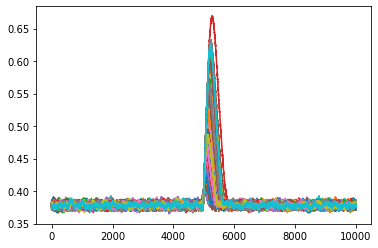

In [10]:
for i in range(100):
    plt.plot(plot_array[i])

### This function will extract the peak from each trace/row of the data set. The noise sample is determined by eye; pick a range of x values where there don't appear to be (many) peaks, ex. from 2000:3500.

In [11]:
peaks = np.zeros(len(plot_array))
max_point = 0
noise_sample = 0

for i in range(len(plot_array)):
    max_point = np.max(plot_array[i])
    noise_sample = np.mean(plot_array[i,2000:2900])
    peaks[i] = max_point - noise_sample

### Save your peak values. Save this data set name as ***data set name_peaks*** ex. "BurstCube_PostVibe_Cs137_061419_run1_peaks."

In [89]:
dset = f.create_dataset('cd_12_50_1_peaks', data=peaks)

### Plot a histogram of the peaks using matplotlib to get a sense of what the data looks like and where the peak is.

(array([ 62.,  76.,  91.,  85.,  97.,  66.,  46.,  63.,  57.,  51.,  40.,
         51.,  49.,  37.,  37.,  50.,  41.,  38.,  33.,  28.,  42.,  41.,
         24.,  22.,  30.,  26.,  22.,  36.,  28.,  31.,  21.,  21.,  23.,
         17.,  18.,  28.,  26.,  20.,  18.,  19.,  23.,  26.,  20.,  20.,
         19.,  17.,  20.,  23.,  30.,  20.,  26.,  21.,  23.,  30.,  19.,
         24.,  15.,  18.,  23.,  12.,  13.,  16.,  13.,   7.,   6.,  19.,
         24.,  14.,  23.,  12.,  13.,   8.,  12.,   8.,  12.,  17.,  13.,
         15.,   9.,  12.,  15.,   9.,  14.,  10.,  18.,  10.,   8.,  14.,
          8.,  14.,  12.,   9.,  12.,  12.,  11.,  11.,   9.,   8.,  10.,
          9.,  19.,  10.,   8.,   9.,   9.,  10.,  12.,   9.,  11.,  10.,
          8.,  13.,  13.,  14.,  19.,  15.,   9.,  11.,  18.,  13.,   9.,
         12.,   7.,  20.,  12.,  14.,  21.,  12.,  10.,   9.,   7.,  18.,
         25.,  19.,  28.,  41.,  30.,  60.,  95., 111., 159., 249., 269.,
        268., 243., 159.,  67.,  31., 

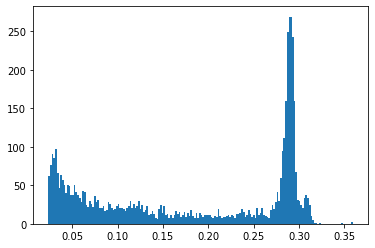

In [63]:
plt.hist(peaks, bins=180)

### Plot a more rigorous histogram and fit the data to find the energy resolution.

In [14]:
bins = np.linspace(0,1,100) # Here, the number of bins has been set to 100 and the length of
# the x axis has been set to one. This can be adjusted; inspect the matplotlib histogram to
# see what the binning / x axis should be.
fit_hist, bins_1 = np.histogram(peaks, bins=bins)
bins_2 = np.array([bins[i] for i in range(len(bins)-1)])

### The scipy.optimize function will fit the histogram of your peaks to a Gaussian. The x data is the bins_2 array and the y data is the output from the np.histogram function. In order for the fit to work, you have to make reasonable guesses for the amplitude, the mean, and the sigma of the histogram.
### Change the title of the plot, save figure if it looks good

[4.18271574e+03 3.58712185e-01 1.60087999e-02]
Amplitude = 4182, Mu = 0.3587, Sigma = 0.0160
The energy resolution is approximately 10.51 percent.


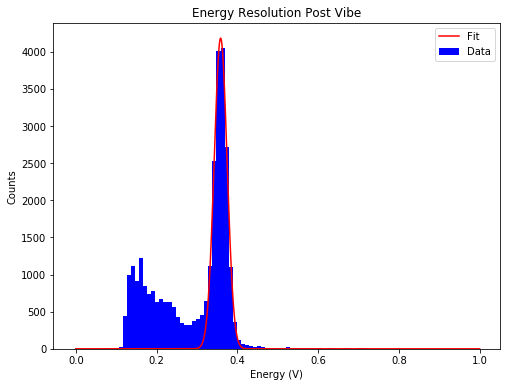

In [15]:
import scipy
from scipy.optimize import curve_fit
import pylab 

x = bins_2
y = fit_hist
xspace = np.linspace(0, 1, 10000) # This creates a smoother plot when plotting the fit

# Guesses for p01: [Amplitude, Mu, Sigma]. These guesses must be reasonable.
p01 = [7500, 0.35, 0.05]

# Define the fit function (a Gaussian)
def Gauss(x, A, mu, sigma):
    return A*np.exp(-(x-mu)**2/(2.0*sigma**2))

# popt returns the best fit values for amplitude, mean, and sigma. pcov returns a covariance
# matrix; the diagonal of this matrix returns the errors associated with the three returned 
# values, which is used to determine the error in the energy resolution.
popt, pcov = curve_fit(Gauss, xdata=bins_2, ydata=fit_hist, p0=p01)

plt.figure(figsize = (8, 6))
# Plot the data
plt.bar(bins_2, fit_hist, width=bins[1] - bins[0], color='blue', label=r'Data')
# Plot the fit
plt.plot(xspace, Gauss(xspace, *popt), 'r-', label='Fit')
(Amp, Mu, Sigma) = popt
# Print the outputs 
print(popt)
print("Amplitude = %d, Mu = %0.4f, Sigma = %0.4f" %(Amp, Mu, Sigma))
energy_res = (2.355*Sigma*100)/Mu # Calculates energy resolution
print("The energy resolution is approximately %0.2f percent." %(energy_res))
plt.legend()
# Change the title of the plot and the saved figure!
# plt.savefig('Energy Resolution Post Vibe')
plt.title('Energy Resolution Post Vibe')
plt.xlabel('Energy (V)')
plt.ylabel('Counts')
plt.show()

### Calculate the errors associated with the energy resolution:

In [16]:
(Amp_err, Mu_err, Sigma_err) = np.sqrt(np.diag(pcov))
# Error propagation
partial_sigma = (2.355*100)/Mu
partial_mu = (2.355*100*Sigma)/(Mu**2)
stdev_er = np.sqrt(((partial_sigma**2)*(Sigma_err**2))+((partial_mu**2)*(Mu_err)**2))
print("Error in amplitude is %0.3f. \nError in mu is %0.6f. \nError in sigma is %0.6f." %(Amp_err, Mu_err, Sigma_err))
print("The error in the energy resolution is %0.5f percent."%(stdev_er))

Error in amplitude is 231.940 
Error in mu is 0.001025 
Error in sigma is 0.001025
The error in the energy resolution is 0.67359 percent.


### If you are done working with a file, ***make sure you close it!*** h5py does not like it when files are left open and you change files and/or kill the kernel.

In [13]:
f.close()

In [12]:
h=open("y_pixel_12_50_10_14_2020.txt", "a")

In [13]:
for m in peaks:
    h.write(str(m)+', ')

In [14]:
h.close()

### Saving the h5py files as text files

In [15]:
f.close()

In [20]:
h=open("fe_0_50_peaks_9_23_2020.txt", "w")

In [21]:
np.savetxt("fe_0_50_peaks_9_23_2020.txt", peaks)

In [22]:
h.close()

In [33]:
test_read = open("fe_pixel_0_50_9_23_2020.txt", "r")

In [34]:
test_read_really = test_read.read()

In [35]:
print(test_read_really)

0.08026888888888889, 0.08704222222222224, 0.08089555555555555, 0.08130888888888888, 0.08542000000000005, 0.08280444444444446, 0.07515111111111106, 0.08038888888888884, 0.0897533333333333, 0.07661111111111107, 0.0874888888888889, 0.07933555555555555, 0.07187111111111105, 0.08266666666666667, 0.09933333333333327, 0.07963333333333339, 0.07980222222222216, 0.030662222222222257, 0.08111999999999991, 0.07640888888888886, 0.08344888888888885, 0.09816444444444444, 0.07941333333333334, 0.08760444444444443, 0.03965777777777779, 0.09059999999999996, 0.0917444444444444, 0.08594222222222225, 0.08754, 0.07279111111111108, 0.04175333333333331, 0.08454666666666671, 0.08336444444444441, 0.07522666666666666, 0.08342444444444436, 0.09125111111111112, 0.08602666666666664, 0.0771155555555556, 0.08774888888888888, 0.05665999999999993, 0.08170222222222218, 0.08800888888888891, 0.07479333333333327, 0.07737555555555559, 0.08391555555555552, 0.07658222222222222, 0.08541777777777781, 0.06314888888888887, 0.08345

YOU DID IT!!!